
# **1- Importing required libraries**

In [1]:
import os 
import torch
import cv2
import csv
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from tqdm.notebook import tqdm 
import torchvision.transforms.functional as TF


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class config:
    batchsize = 8
    num_epochs = 50
    learning_rate = 1e-4
    num_classes = 4

In [4]:
pd.set_option('future.no_silent_downcasting', True)

# **2 - Data Preprocessing**

In [5]:
dataset_path = "/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos"
csv_path = "/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/microscopy_ground_truth.csv"

df = pd.read_csv(csv_path)
image_paths, labels = [], []

for class_name in ["Benign", "InSitu", "Invasive", "Normal"]:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        if img_name.endswith(".tif"):  
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)


image_df = pd.DataFrame({"image_path": image_paths, "label": labels})

image_df["label"] = image_df["label"].replace({"Normal": 0, "Benign": 1, "InSitu": 2, "Invasive": 3}).astype("int64")
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)
image_df.to_csv("bach_training_data.csv", index=False)

dataset = pd.read_csv("bach_training_data.csv")
dataset.head()

image_path  label
0  /kaggle/input/bach-breast-cancer-histology-ima...      3
1  /kaggle/input/bach-breast-cancer-histology-ima...      3
2  /kaggle/input/bach-breast-cancer-histology-ima...      1
3  /kaggle/input/bach-breast-cancer-histology-ima...      3
4  /kaggle/input/bach-breast-cancer-histology-ima...      1

In [6]:
class BACHDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = torch.tensor(self.data.iloc[idx]["label"], dtype=torch.long)
        image = Image.open(img_path).convert("RGB")
        image = cv2.resize(np.array(image), (224, 224), interpolation=cv2.INTER_AREA)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)  

        return image, label

class MinMaxScalerTransform:
    def __call__(self, img):
        img_array = np.array(img).astype(np.float32) / 255.0
        return torch.tensor(img_array).permute(2, 0, 1)

data_transforms = transforms.Compose([
    MinMaxScalerTransform(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# **3 - Data Loaders**

In [7]:
train, temp = train_test_split(dataset, test_size=0.2, stratify=dataset["label"], random_state=42)
val, test = train_test_split(temp, test_size=0.25, stratify=temp["label"], random_state=42)

train_dataset = BACHDataset(train, transform=data_transforms)
val_dataset = BACHDataset(val, transform=None)
test_dataset = BACHDataset(test, transform=None)

train_dataloader = DataLoader(train_dataset, batch_size=config.batchsize, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config.batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.batchsize, shuffle=True)

# **4 - Visualise Samples**


Train Samples - Total Batches: 40 | Total Samples: 320


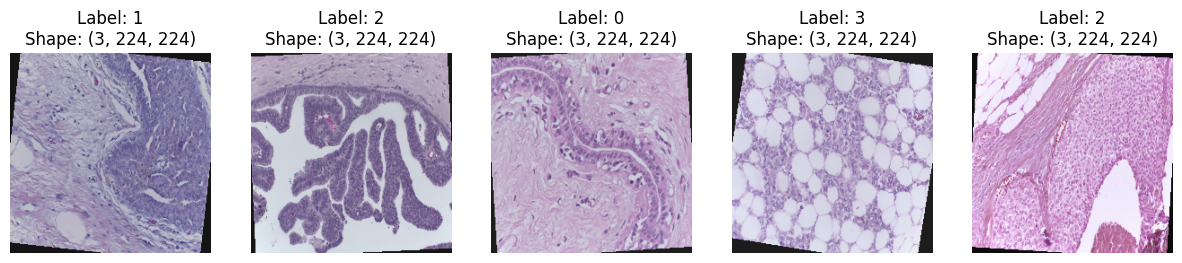


Validation Samples - Total Batches: 8 | Total Samples: 60


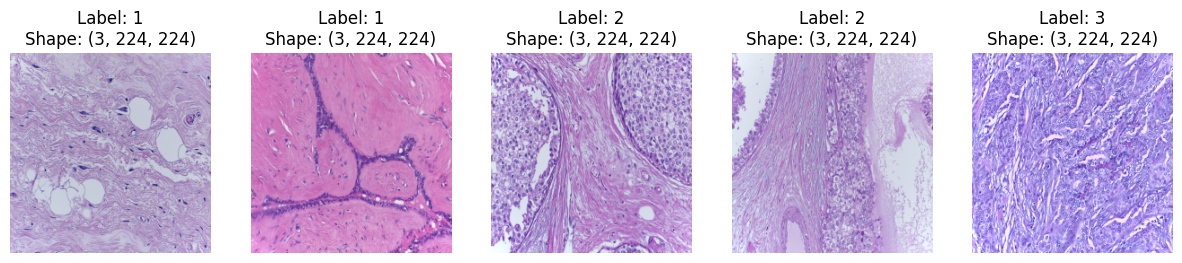


Test Samples - Total Batches: 3 | Total Samples: 20


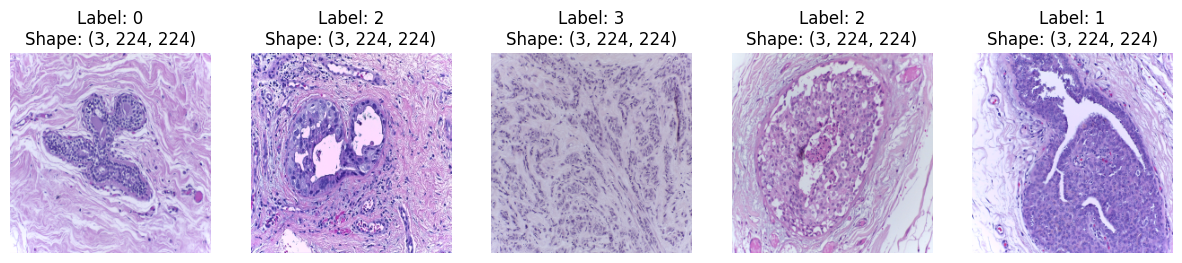

In [8]:


def show_samples(dataloader, title, num_samples=5):
    print(f"\n{title} - Total Batches: {len(dataloader)} | Total Samples: {len(dataloader.dataset)}")


    batch = next(iter(dataloader))

    if isinstance(batch, tuple) and len(batch) == 2: 
        images, labels = batch
    elif isinstance(batch, list) and len(batch) == 2:
        images, labels = batch[0], batch[1]
    else:
        raise ValueError(f"Unexpected batch format from DataLoader: {type(batch)}, content: {batch}")

   
    if isinstance(images, list):
        images = torch.stack(images)
    
    
    if images.ndim == 3:
        images = images.unsqueeze(0) 

    num_samples = min(num_samples, images.shape[0]) 


    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]  
    for i in range(num_samples):
        img_tensor = images[i] 
        img = TF.to_pil_image(img_tensor.cpu())  
        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        img_shape = tuple(img_tensor.shape)  

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}\nShape: {img_shape}")  
        axes[i].axis("off")

      

    plt.show()

show_samples(train_dataloader, "Train Samples")
show_samples(val_dataloader, "Validation Samples")
show_samples(test_dataloader, "Test Samples")

# **5 -  ResNet - 50 Model**

In [9]:

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


for param in model.layer1.parameters() :
        param.requires_grad = False
for param in model.layer2.parameters() :
        param.requires_grad = False
for param in model.layer3.parameters() :
        param.requires_grad = False
for param in model.layer4.parameters() :
        param.requires_grad = True
num_features = model.fc.in_features  
num_classes = 4  


model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),  
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),  
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256), 
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)  
)


model = model.to(device)


criterion = nn.CrossEntropyLoss()


class_weights = torch.tensor([1.0, 1.5, 1.0, 1.0], dtype=torch.float32).to(device)  


criterion_w = nn.CrossEntropyLoss(weight=class_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-4)



scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# **6 - Function Definintions**

In [10]:
import torch
import torch.nn.functional as F

def convert_to_one_hot(label, num_classes):
    
    
    return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)

def compute_multiclass_metrics(preds_list, labels_list, num_classes):
   
    # Initialize per-class metric accumulators
    TP_per_class = torch.zeros(num_classes)
    TN_per_class = torch.zeros(num_classes)
    FP_per_class = torch.zeros(num_classes)
    FN_per_class = torch.zeros(num_classes)

    correct = 0
    total = len(labels_list)

    for preds, label in zip(preds_list, labels_list):
         
        label_one_hot = convert_to_one_hot(label, num_classes)   

      
        pred_class = torch.argmax(preds)   
        pred_one_hot = convert_to_one_hot(preds, num_classes)   

   
        if preds == label:
            correct += 1

       
        for class_idx in range(num_classes):
            
            TP_per_class[class_idx] += int((pred_one_hot[class_idx] == 1) and (label_one_hot[class_idx] == 1))
            
            TN_per_class[class_idx] += int((pred_one_hot[class_idx] == 0) and (label_one_hot[class_idx] == 0))
            
            FP_per_class[class_idx] += int((pred_one_hot[class_idx] == 1) and (label_one_hot[class_idx] == 0))
            
            FN_per_class[class_idx] += int((pred_one_hot[class_idx] == 0) and (label_one_hot[class_idx] == 1))
             
  
    precision_per_class = TP_per_class / (TP_per_class + FP_per_class).clamp(min=1e-10)
     
    recall_per_class = TP_per_class / (TP_per_class + FN_per_class).clamp(min=1e-10)
    
    specificity_per_class = TN_per_class / (TN_per_class + FP_per_class).clamp(min=1e-10)
    
    f1_score_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class).clamp(min=1e-10)
    

    
    macro_precision = precision_per_class.mean().item()
    macro_recall = recall_per_class.mean().item()
    macro_specificity = specificity_per_class.mean().item()
    macro_f1_score = f1_score_per_class.mean().item()

     
    accuracy = correct / total

    return {
        "accuracy": accuracy,
        "precision_per_class": precision_per_class.tolist(),
        "macro_precision": macro_precision,
        "recall_per_class": recall_per_class.tolist(),
        "macro_recall": macro_recall,
        "specificity_per_class": specificity_per_class.tolist(),
        "macro_specificity": macro_specificity,
        "f1_score_per_class": f1_score_per_class.tolist(),
        "macro_f1_score": macro_f1_score
    }

In [11]:
def plot_loss(train_losses, val_losses, num_epochs):
    """Plots training and validation loss curves."""
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
def train_model(model, optimizer, criterion, train_dataloader, val_dataloader, num_epochs, device, num_classes, model_path, csv_name):
     
    log_fields = ["epoch", "time", "train_loss", "val_loss", "train_precision", "val_precision", 
              "train_recall", "val_recall", "train_F1_Score", "val_F1_Score"]
    total_training_time = 0 
    best_val_F1_Score = 0

    train_losses = []
    val_losses = []  
        
    with open(csv_name, 'w', newline='', encoding='utf-8') as csvfile:
         writer = csv.DictWriter(csvfile, fieldnames=log_fields)
         writer.writeheader()

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        
        total_loss = 0
        correct = 0
        total = 0
        
        all_preds = []
        all_labels = []
        


        train_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
        
        for images, labels in train_iterator:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = F.softmax(outputs, dim=1)    
            preds = torch.argmax(preds, dim=1)   
            correct += (preds == labels).sum().item()
            total += labels.size(0)

             
            all_preds.append(preds.detach().cpu())
            all_labels.append(labels.detach().cpu())

            train_iterator.set_postfix(loss=f"{loss:.4f}")
        
        epoch_time = time.time() - start_time
        total_training_time += epoch_time
        accuracy = correct / total
        
        
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
         
         
        metrics = compute_multiclass_metrics(all_preds, all_labels, num_classes)
          
        epoch_train_loss = total_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)


        # Print metrics for each class
        print(f"Epoch {epoch + 1} - Loss: {epoch_train_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f}s")
        print(f"Macro Precision: {metrics['macro_precision']:.4f}, Macro Recall: {metrics['macro_recall']:.4f}, Macro F1-score: {metrics['macro_f1_score']:.4f}")
        
        for class_idx in range(num_classes):
            print(f"Class {class_idx} - Precision: {metrics['precision_per_class'][class_idx]:.4f}, Recall: {metrics['recall_per_class'][class_idx]:.4f}, F1-score: {metrics['f1_score_per_class'][class_idx]:.4f}")

        all_val_preds,all_val_labels,val_accuracy, val_loss = valid_model(model,criterion, val_dataloader, device, epoch, num_classes)
        val_metrics = compute_multiclass_metrics(all_val_preds, all_val_labels, num_classes)
        val_losses.append(val_loss)
        print("Validation_Metrics")
        print(f"Epoch {epoch + 1} - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        print(f"Macro Precision: {val_metrics['macro_precision']:.4f}, Macro Recall: {val_metrics['macro_recall']:.4f}, Macro F1-score: {val_metrics['macro_f1_score']:.4f}")
            
        for class_idx in range(num_classes):
            print(f"Class {class_idx} - Precision: {val_metrics['precision_per_class'][class_idx]:.4f}, Recall: {val_metrics['recall_per_class'][class_idx]:.4f}, F1-score: {val_metrics['f1_score_per_class'][class_idx]:.4f}")
    
            # Save best model based on Dice score
        if val_metrics['macro_f1_score'] > best_val_F1_Score:
            best_val_F1_Score = val_metrics['macro_f1_score']
            torch.save(model.state_dict(), model_path)
            print(f"Model saved at epoch {epoch+1} with F1_score: {best_val_F1_Score:.4f}")
            # Log training and validation metrics
        with open(csv_name, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=log_fields)
            writer.writerow({
                "epoch": epoch + 1,
                "time": round(epoch_time, 2),
                "train_loss": round(total_loss/len(train_dataloader), 4),
                "val_loss": round(val_loss, 4),
                "train_precision": round(metrics['macro_precision'], 4),
                "val_precision": round(val_metrics['macro_precision'], 4),
                "train_recall": round(metrics['macro_recall'], 4),
                "val_recall": round(val_metrics['macro_recall'], 4),
                "train_F1_Score": round(metrics['macro_f1_score'], 4),
                "val_F1_Score": round(val_metrics['macro_f1_score'], 4),
                
            })


    print(f"Training Complete in {total_training_time:.4f}s with {total_training_time/num_epochs:.4f}s per epoch with Best_F1_Score {best_val_F1_Score:.4f}.")
    print(f"Best Validation F1 Score: {best_val_F1_Score:.4f}")

    plot_loss(train_losses, val_losses, num_epochs)

In [13]:
def valid_model(model,criterion, dataloader, device, epoch, num_classes):

    all_val_preds = []
    all_val_labels = []
    val_loss = 0
    val_correct = 0
    val_total= 0
    model.eval()

    val_iterator = tqdm(dataloader, desc=f"Epoch {epoch + 1}")
    
    with torch.no_grad():   
            for images,labels  in val_iterator:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
    
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = F.softmax(outputs, dim=1)    
                preds = torch.argmax(preds, dim=1)   
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
    
             
                all_val_preds.append(preds.detach().cpu())
                all_val_labels.append(labels.detach().cpu())
    
    val_iterator.set_postfix(loss=f"{loss:.4f}")
    val_accuracy = val_correct / val_total
    all_val_preds = torch.cat(all_val_preds, dim=0)
    all_val_labels = torch.cat(all_val_labels, dim=0) 
    val_loss /= len(dataloader)
    scheduler.step(val_loss)   

    return all_val_preds,all_val_labels,val_accuracy, val_loss
     

In [14]:
def inference_model(model, model_path, dataloader, device, num_classes):
    
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()  
    
    all_preds = []
    all_labels = []
    
    inference_iterator = tqdm(dataloader, desc="Running Inference")
    
    start_time = time.time()

    with torch.no_grad():   
        for images, labels in inference_iterator:
            images, labels = images.to(device), labels.to(device)   
            outputs = model(images)   
            
            preds = F.softmax(outputs, dim=1)   
            preds = torch.argmax(preds, dim=1)   
            
            
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

     
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

     
    metrics = compute_multiclass_metrics(all_preds, all_labels, num_classes)

     
    inference_time = time.time() - start_time
    print(f"\nInference Completed in {inference_time:.2f}s")

    print(f"\nMacro Precision: {metrics['macro_precision']:.4f}, Macro Recall: {metrics['macro_recall']:.4f}, Macro F1-score: {metrics['macro_f1_score']:.4f}")

    for class_idx in range(num_classes):
        print(f"Class {class_idx} - Precision: {metrics['precision_per_class'][class_idx]:.4f}, Recall: {metrics['recall_per_class'][class_idx]:.4f}, F1-score: {metrics['f1_score_per_class'][class_idx]:.4f}")

    


# **7 - Training and Validation with Cross Entropy Loss**

Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Loss: 1.3811, Accuracy: 0.2875, Time: 65.43s
Macro Precision: 0.5060, Macro Recall: 0.2875, Macro F1-score: 0.1850
Class 0 - Precision: 0.2621, Recall: 0.9500, F1-score: 0.4108
Class 1 - Precision: 0.1429, Recall: 0.0125, F1-score: 0.0230
Class 2 - Precision: 1.0000, Recall: 0.0250, F1-score: 0.0488
Class 3 - Precision: 0.6190, Recall: 0.1625, F1-score: 0.2574


<ipython-input-10-01d6a2be464f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)


Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 1 - Loss: 1.3614, Accuracy: 0.4667
Macro Precision: 0.5352, Macro Recall: 0.4667, Macro F1-score: 0.3584
Class 0 - Precision: 0.3409, Recall: 1.0000, F1-score: 0.5085
Class 1 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 2 - Precision: 1.0000, Recall: 0.0667, F1-score: 0.1250
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000
Model saved at epoch 1 with F1_score: 0.3584


Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Loss: 1.2982, Accuracy: 0.4719, Time: 21.42s
Macro Precision: 0.4793, Macro Recall: 0.4719, Macro F1-score: 0.4532
Class 0 - Precision: 0.3919, Recall: 0.7250, F1-score: 0.5088
Class 1 - Precision: 0.3019, Recall: 0.2000, F1-score: 0.2406
Class 2 - Precision: 0.4667, Recall: 0.2625, F1-score: 0.3360
Class 3 - Precision: 0.7568, Recall: 0.7000, F1-score: 0.7273


Epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 2 - Loss: 1.1144, Accuracy: 0.5833
Macro Precision: 0.4675, Macro Recall: 0.5833, Macro F1-score: 0.4973
Class 0 - Precision: 0.4688, Recall: 1.0000, F1-score: 0.6383
Class 1 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 2 - Precision: 0.6364, Recall: 0.4667, F1-score: 0.5385
Class 3 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Model saved at epoch 2 with F1_score: 0.4973


Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Loss: 1.0468, Accuracy: 0.5844, Time: 21.06s
Macro Precision: 0.5463, Macro Recall: 0.5844, Macro F1-score: 0.5474
Class 0 - Precision: 0.5214, Recall: 0.7625, F1-score: 0.6193
Class 1 - Precision: 0.3103, Recall: 0.1125, F1-score: 0.1651
Class 2 - Precision: 0.5824, Recall: 0.6625, F1-score: 0.6199
Class 3 - Precision: 0.7711, Recall: 0.8000, F1-score: 0.7853


Epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 3 - Loss: 0.7641, Accuracy: 0.6833
Macro Precision: 0.5221, Macro Recall: 0.6833, Macro F1-score: 0.5908
Class 0 - Precision: 0.6842, Recall: 0.8667, F1-score: 0.7647
Class 1 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 2 - Precision: 0.6818, Recall: 1.0000, F1-score: 0.8108
Class 3 - Precision: 0.7222, Recall: 0.8667, F1-score: 0.7879
Model saved at epoch 3 with F1_score: 0.5908


Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Loss: 0.8362, Accuracy: 0.6687, Time: 20.91s
Macro Precision: 0.6538, Macro Recall: 0.6687, Macro F1-score: 0.6458
Class 0 - Precision: 0.6226, Recall: 0.8250, F1-score: 0.7097
Class 1 - Precision: 0.5250, Recall: 0.2625, F1-score: 0.3500
Class 2 - Precision: 0.6774, Recall: 0.7875, F1-score: 0.7283
Class 3 - Precision: 0.7901, Recall: 0.8000, F1-score: 0.7950


Epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 4 - Loss: 0.6249, Accuracy: 0.7667
Macro Precision: 0.7748, Macro Recall: 0.7667, Macro F1-score: 0.7298
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.8000, Recall: 0.2667, F1-score: 0.4000
Class 2 - Precision: 0.7500, Recall: 1.0000, F1-score: 0.8571
Class 3 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Model saved at epoch 4 with F1_score: 0.7298


Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.6691, Accuracy: 0.7156, Time: 20.88s
Macro Precision: 0.7021, Macro Recall: 0.7156, Macro F1-score: 0.6931
Class 0 - Precision: 0.6381, Recall: 0.8375, F1-score: 0.7243
Class 1 - Precision: 0.5854, Recall: 0.3000, F1-score: 0.3967
Class 2 - Precision: 0.7738, Recall: 0.8125, F1-score: 0.7927
Class 3 - Precision: 0.8111, Recall: 0.9125, F1-score: 0.8588


Epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 5 - Loss: 0.6343, Accuracy: 0.8000
Macro Precision: 0.8094, Macro Recall: 0.8000, Macro F1-score: 0.7923
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.8000, Recall: 0.5333, F1-score: 0.6400
Class 2 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571
Class 3 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Model saved at epoch 5 with F1_score: 0.7923


Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.5346, Accuracy: 0.8125, Time: 20.63s
Macro Precision: 0.8129, Macro Recall: 0.8125, Macro F1-score: 0.8072
Class 0 - Precision: 0.7419, Recall: 0.8625, F1-score: 0.7977
Class 1 - Precision: 0.7966, Recall: 0.5875, F1-score: 0.6763
Class 2 - Precision: 0.8395, Recall: 0.8500, F1-score: 0.8447
Class 3 - Precision: 0.8736, Recall: 0.9500, F1-score: 0.9102


Epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 6 - Loss: 0.5268, Accuracy: 0.8167
Macro Precision: 0.8184, Macro Recall: 0.8167, Macro F1-score: 0.8027
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.7778, Recall: 0.4667, F1-score: 0.5833
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Model saved at epoch 6 with F1_score: 0.8027


Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.4532, Accuracy: 0.8313, Time: 20.59s
Macro Precision: 0.8287, Macro Recall: 0.8312, Macro F1-score: 0.8293
Class 0 - Precision: 0.8415, Recall: 0.8625, F1-score: 0.8519
Class 1 - Precision: 0.7500, Recall: 0.6750, F1-score: 0.7105
Class 2 - Precision: 0.8452, Recall: 0.8875, F1-score: 0.8659
Class 3 - Precision: 0.8780, Recall: 0.9000, F1-score: 0.8889


Epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 7 - Loss: 0.5044, Accuracy: 0.8333
Macro Precision: 0.8438, Macro Recall: 0.8333, Macro F1-score: 0.8272
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.8000, Recall: 0.5333, F1-score: 0.6400
Class 2 - Precision: 0.7000, Recall: 0.9333, F1-score: 0.8000
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Model saved at epoch 7 with F1_score: 0.8272


Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 - Loss: 0.3829, Accuracy: 0.8750, Time: 20.76s
Macro Precision: 0.8741, Macro Recall: 0.8750, Macro F1-score: 0.8736
Class 0 - Precision: 0.8889, Recall: 0.9000, F1-score: 0.8944
Class 1 - Precision: 0.7973, Recall: 0.7375, F1-score: 0.7662
Class 2 - Precision: 0.9351, Recall: 0.9000, F1-score: 0.9172
Class 3 - Precision: 0.8750, Recall: 0.9625, F1-score: 0.9167


Epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 8 - Loss: 0.3615, Accuracy: 0.8500
Macro Precision: 0.8557, Macro Recall: 0.8500, Macro F1-score: 0.8465
Class 0 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Model saved at epoch 8 with F1_score: 0.8465


Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 - Loss: 0.3245, Accuracy: 0.8906, Time: 20.82s
Macro Precision: 0.8910, Macro Recall: 0.8906, Macro F1-score: 0.8904
Class 0 - Precision: 0.8659, Recall: 0.8875, F1-score: 0.8765
Class 1 - Precision: 0.8481, Recall: 0.8375, F1-score: 0.8428
Class 2 - Precision: 0.9333, Recall: 0.8750, F1-score: 0.9032
Class 3 - Precision: 0.9167, Recall: 0.9625, F1-score: 0.9390


Epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 9 - Loss: 0.3360, Accuracy: 0.8500
Macro Precision: 0.8569, Macro Recall: 0.8500, Macro F1-score: 0.8437
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 - Loss: 0.2790, Accuracy: 0.8938, Time: 20.69s
Macro Precision: 0.8932, Macro Recall: 0.8937, Macro F1-score: 0.8932
Class 0 - Precision: 0.8625, Recall: 0.8625, F1-score: 0.8625
Class 1 - Precision: 0.8442, Recall: 0.8125, F1-score: 0.8280
Class 2 - Precision: 0.9494, Recall: 0.9375, F1-score: 0.9434
Class 3 - Precision: 0.9167, Recall: 0.9625, F1-score: 0.9390


Epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 10 - Loss: 0.4164, Accuracy: 0.8500
Macro Precision: 0.8618, Macro Recall: 0.8500, Macro F1-score: 0.8401
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.7500, Recall: 1.0000, F1-score: 0.8571
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032


Epoch 11:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11 - Loss: 0.2262, Accuracy: 0.9219, Time: 20.78s
Macro Precision: 0.9211, Macro Recall: 0.9219, Macro F1-score: 0.9214
Class 0 - Precision: 0.9125, Recall: 0.9125, F1-score: 0.9125
Class 1 - Precision: 0.8701, Recall: 0.8375, F1-score: 0.8535
Class 2 - Precision: 0.9506, Recall: 0.9625, F1-score: 0.9565
Class 3 - Precision: 0.9512, Recall: 0.9750, F1-score: 0.9630


Epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 11 - Loss: 0.4669, Accuracy: 0.8833
Macro Precision: 0.8920, Macro Recall: 0.8833, Macro F1-score: 0.8818
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Model saved at epoch 11 with F1_score: 0.8818


Epoch 12:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12 - Loss: 0.2178, Accuracy: 0.9375, Time: 20.67s
Macro Precision: 0.9377, Macro Recall: 0.9375, Macro F1-score: 0.9375
Class 0 - Precision: 0.9157, Recall: 0.9500, F1-score: 0.9325
Class 1 - Precision: 0.8987, Recall: 0.8875, F1-score: 0.8931
Class 2 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 3 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750


Epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 12 - Loss: 0.3963, Accuracy: 0.9000
Macro Precision: 0.9019, Macro Recall: 0.9000, Macro F1-score: 0.8949
Class 0 - Precision: 0.9375, Recall: 1.0000, F1-score: 0.9677
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.9375, Recall: 1.0000, F1-score: 0.9677
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Model saved at epoch 12 with F1_score: 0.8949


Epoch 13:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13 - Loss: 0.1940, Accuracy: 0.9344, Time: 20.84s
Macro Precision: 0.9346, Macro Recall: 0.9344, Macro F1-score: 0.9344
Class 0 - Precision: 0.9487, Recall: 0.9250, F1-score: 0.9367
Class 1 - Precision: 0.8765, Recall: 0.8875, F1-score: 0.8820
Class 2 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 3 - Precision: 0.9506, Recall: 0.9625, F1-score: 0.9565


Epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 13 - Loss: 0.4023, Accuracy: 0.8500
Macro Precision: 0.8555, Macro Recall: 0.8500, Macro F1-score: 0.8329
Class 0 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 1 - Precision: 0.8750, Recall: 0.4667, F1-score: 0.6087
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032


Epoch 14:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14 - Loss: 0.1468, Accuracy: 0.9469, Time: 20.89s
Macro Precision: 0.9471, Macro Recall: 0.9469, Macro F1-score: 0.9469
Class 0 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 1 - Precision: 0.9241, Recall: 0.9125, F1-score: 0.9182
Class 2 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 3 - Precision: 0.9277, Recall: 0.9625, F1-score: 0.9448


Epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 14 - Loss: 0.3203, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8334
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8750, Recall: 0.4667, F1-score: 0.6087
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333


Epoch 15:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15 - Loss: 0.1080, Accuracy: 0.9656, Time: 20.50s
Macro Precision: 0.9658, Macro Recall: 0.9656, Macro F1-score: 0.9656
Class 0 - Precision: 0.9398, Recall: 0.9750, F1-score: 0.9571
Class 1 - Precision: 0.9487, Recall: 0.9250, F1-score: 0.9367
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811


Epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 15 - Loss: 0.3492, Accuracy: 0.8667
Macro Precision: 0.8667, Macro Recall: 0.8667, Macro F1-score: 0.8605
Class 0 - Precision: 0.9375, Recall: 1.0000, F1-score: 0.9677
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 16:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16 - Loss: 0.1175, Accuracy: 0.9656, Time: 20.92s
Macro Precision: 0.9656, Macro Recall: 0.9656, Macro F1-score: 0.9655
Class 0 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 1 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 2 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 3 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753


Epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 16 - Loss: 0.5150, Accuracy: 0.8500
Macro Precision: 0.8560, Macro Recall: 0.8500, Macro F1-score: 0.8390
Class 0 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032


Epoch 17:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17 - Loss: 0.0883, Accuracy: 0.9719, Time: 20.85s
Macro Precision: 0.9719, Macro Recall: 0.9719, Macro F1-score: 0.9719
Class 0 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 1 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 2 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 3 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811


Epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 17 - Loss: 0.5207, Accuracy: 0.8500
Macro Precision: 0.8618, Macro Recall: 0.8500, Macro F1-score: 0.8401
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.7500, Recall: 1.0000, F1-score: 0.8571
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032


Epoch 18:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18 - Loss: 0.0681, Accuracy: 0.9719, Time: 21.04s
Macro Precision: 0.9720, Macro Recall: 0.9719, Macro F1-score: 0.9718
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753


Epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 18 - Loss: 0.4795, Accuracy: 0.8667
Macro Precision: 0.8734, Macro Recall: 0.8667, Macro F1-score: 0.8598
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 19:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19 - Loss: 0.0498, Accuracy: 0.9906, Time: 20.77s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 19 - Loss: 0.3287, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 - Loss: 0.0421, Accuracy: 0.9875, Time: 20.60s
Macro Precision: 0.9881, Macro Recall: 0.9875, Macro F1-score: 0.9876
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9524, Recall: 1.0000, F1-score: 0.9756
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873


Epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 20 - Loss: 0.4066, Accuracy: 0.8833
Macro Precision: 0.8923, Macro Recall: 0.8833, Macro F1-score: 0.8802
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 21:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21 - Loss: 0.0749, Accuracy: 0.9688, Time: 20.85s
Macro Precision: 0.9685, Macro Recall: 0.9688, Macro F1-score: 0.9686
Class 0 - Precision: 0.9494, Recall: 0.9375, F1-score: 0.9434
Class 1 - Precision: 0.9494, Recall: 0.9375, F1-score: 0.9434
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 21 - Loss: 0.2864, Accuracy: 0.8667
Macro Precision: 0.8683, Macro Recall: 0.8667, Macro F1-score: 0.8651
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857
Class 2 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 22:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22 - Loss: 0.0638, Accuracy: 0.9781, Time: 20.67s
Macro Precision: 0.9785, Macro Recall: 0.9781, Macro F1-score: 0.9781
Class 0 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 1 - Precision: 0.9870, Recall: 0.9500, F1-score: 0.9682
Class 2 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 22 - Loss: 0.3292, Accuracy: 0.8667
Macro Precision: 0.8694, Macro Recall: 0.8667, Macro F1-score: 0.8640
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 23:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23 - Loss: 0.0573, Accuracy: 0.9781, Time: 20.54s
Macro Precision: 0.9782, Macro Recall: 0.9781, Macro F1-score: 0.9781
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 23 - Loss: 0.4262, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 24:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24 - Loss: 0.0394, Accuracy: 0.9906, Time: 20.50s
Macro Precision: 0.9906, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 24 - Loss: 0.3849, Accuracy: 0.8667
Macro Precision: 0.8778, Macro Recall: 0.8667, Macro F1-score: 0.8608
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 25:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25 - Loss: 0.0348, Accuracy: 0.9969, Time: 20.59s
Macro Precision: 0.9969, Macro Recall: 0.9969, Macro F1-score: 0.9969
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 25 - Loss: 0.4122, Accuracy: 0.8500
Macro Precision: 0.8587, Macro Recall: 0.8500, Macro F1-score: 0.8442
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 26:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26 - Loss: 0.0422, Accuracy: 0.9812, Time: 20.70s
Macro Precision: 0.9812, Macro Recall: 0.9812, Macro F1-score: 0.9812
Class 0 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 1 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 26 - Loss: 0.3590, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 27:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27 - Loss: 0.0604, Accuracy: 0.9812, Time: 20.82s
Macro Precision: 0.9814, Macro Recall: 0.9812, Macro F1-score: 0.9813
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 27 - Loss: 0.4012, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 28:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28 - Loss: 0.0549, Accuracy: 0.9875, Time: 20.61s
Macro Precision: 0.9876, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 28 - Loss: 0.4161, Accuracy: 0.8500
Macro Precision: 0.8569, Macro Recall: 0.8500, Macro F1-score: 0.8437
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 29:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29 - Loss: 0.0345, Accuracy: 0.9938, Time: 20.69s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 29 - Loss: 0.3895, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 30:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30 - Loss: 0.0395, Accuracy: 0.9906, Time: 20.67s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 30 - Loss: 0.3794, Accuracy: 0.8667
Macro Precision: 0.8783, Macro Recall: 0.8667, Macro F1-score: 0.8607
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 31:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31 - Loss: 0.0231, Accuracy: 0.9938, Time: 20.75s
Macro Precision: 0.9939, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 2 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 31 - Loss: 0.3807, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 32:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32 - Loss: 0.0255, Accuracy: 0.9969, Time: 20.86s
Macro Precision: 0.9969, Macro Recall: 0.9969, Macro F1-score: 0.9969
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 32 - Loss: 0.3758, Accuracy: 0.8667
Macro Precision: 0.8778, Macro Recall: 0.8667, Macro F1-score: 0.8608
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 33:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33 - Loss: 0.0290, Accuracy: 0.9938, Time: 20.67s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 33 - Loss: 0.4339, Accuracy: 0.8500
Macro Precision: 0.8583, Macro Recall: 0.8500, Macro F1-score: 0.8394
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 34:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34 - Loss: 0.0383, Accuracy: 0.9906, Time: 20.57s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873


Epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 34 - Loss: 0.3823, Accuracy: 0.8667
Macro Precision: 0.8752, Macro Recall: 0.8667, Macro F1-score: 0.8564
Class 0 - Precision: 0.9375, Recall: 1.0000, F1-score: 0.9677
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.9375, Recall: 1.0000, F1-score: 0.9677
Class 3 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235


Epoch 35:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35 - Loss: 0.0221, Accuracy: 1.0000, Time: 20.68s
Macro Precision: 1.0000, Macro Recall: 1.0000, Macro F1-score: 1.0000
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 35 - Loss: 0.4196, Accuracy: 0.8500
Macro Precision: 0.8640, Macro Recall: 0.8500, Macro F1-score: 0.8408
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 36:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36 - Loss: 0.0349, Accuracy: 0.9906, Time: 20.68s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 36 - Loss: 0.3908, Accuracy: 0.8333
Macro Precision: 0.8323, Macro Recall: 0.8333, Macro F1-score: 0.8273
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 37:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37 - Loss: 0.0310, Accuracy: 0.9938, Time: 21.02s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 37 - Loss: 0.3803, Accuracy: 0.8833
Macro Precision: 0.8915, Macro Recall: 0.8833, Macro F1-score: 0.8797
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 38:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38 - Loss: 0.0180, Accuracy: 0.9969, Time: 20.75s
Macro Precision: 0.9969, Macro Recall: 0.9969, Macro F1-score: 0.9969
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 38 - Loss: 0.4340, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 39:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39 - Loss: 0.0263, Accuracy: 0.9906, Time: 20.64s
Macro Precision: 0.9908, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 39 - Loss: 0.3722, Accuracy: 0.8833
Macro Precision: 0.8858, Macro Recall: 0.8833, Macro F1-score: 0.8751
Class 0 - Precision: 0.9375, Recall: 1.0000, F1-score: 0.9677
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 40:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40 - Loss: 0.0354, Accuracy: 0.9906, Time: 20.76s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 40 - Loss: 0.3911, Accuracy: 0.8667
Macro Precision: 0.8770, Macro Recall: 0.8667, Macro F1-score: 0.8569
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235


Epoch 41:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41 - Loss: 0.0288, Accuracy: 0.9875, Time: 20.67s
Macro Precision: 0.9877, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 41 - Loss: 0.3760, Accuracy: 0.8500
Macro Precision: 0.8549, Macro Recall: 0.8500, Macro F1-score: 0.8453
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 42:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42 - Loss: 0.0318, Accuracy: 0.9906, Time: 21.04s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 42 - Loss: 0.3654, Accuracy: 0.8500
Macro Precision: 0.8496, Macro Recall: 0.8500, Macro F1-score: 0.8439
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 43:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43 - Loss: 0.0372, Accuracy: 0.9938, Time: 21.06s
Macro Precision: 0.9937, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 43 - Loss: 0.3446, Accuracy: 0.8833
Macro Precision: 0.8915, Macro Recall: 0.8833, Macro F1-score: 0.8797
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 44:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44 - Loss: 0.0385, Accuracy: 0.9844, Time: 20.63s
Macro Precision: 0.9843, Macro Recall: 0.9844, Macro F1-score: 0.9843
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 44 - Loss: 0.3643, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 45:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45 - Loss: 0.0234, Accuracy: 0.9906, Time: 20.57s
Macro Precision: 0.9910, Macro Recall: 0.9906, Macro F1-score: 0.9907
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 45 - Loss: 0.4283, Accuracy: 0.8667
Macro Precision: 0.8701, Macro Recall: 0.8667, Macro F1-score: 0.8641
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 46:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46 - Loss: 0.0394, Accuracy: 0.9812, Time: 20.57s
Macro Precision: 0.9812, Macro Recall: 0.9812, Macro F1-score: 0.9812
Class 0 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 1 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 46 - Loss: 0.3937, Accuracy: 0.8500
Macro Precision: 0.8496, Macro Recall: 0.8500, Macro F1-score: 0.8439
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 47:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47 - Loss: 0.0526, Accuracy: 0.9875, Time: 20.75s
Macro Precision: 0.9877, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 1 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 47 - Loss: 0.4253, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 48:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48 - Loss: 0.0169, Accuracy: 0.9969, Time: 21.10s
Macro Precision: 0.9969, Macro Recall: 0.9969, Macro F1-score: 0.9969
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 48 - Loss: 0.3832, Accuracy: 0.8833
Macro Precision: 0.8915, Macro Recall: 0.8833, Macro F1-score: 0.8797
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 49:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49 - Loss: 0.0453, Accuracy: 0.9906, Time: 20.67s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 49 - Loss: 0.4268, Accuracy: 0.8500
Macro Precision: 0.8656, Macro Recall: 0.8500, Macro F1-score: 0.8411
Class 0 - Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.7500, Recall: 1.0000, F1-score: 0.8571
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 50:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50 - Loss: 0.0484, Accuracy: 0.9812, Time: 20.88s
Macro Precision: 0.9812, Macro Recall: 0.9812, Macro F1-score: 0.9812
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 2 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 50 - Loss: 0.3341, Accuracy: 0.8667
Macro Precision: 0.8734, Macro Recall: 0.8667, Macro F1-score: 0.8598
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Training Complete in 1082.9807s with 21.6596s per epoch with Best_F1_Score 0.8949.
Best Validation F1 Score: 0.8949


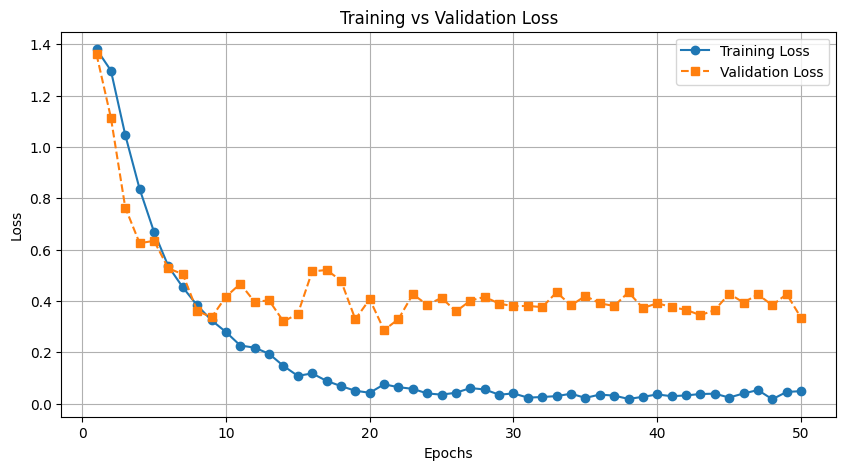

In [15]:
train_model(model, optimizer, criterion, train_dataloader, val_dataloader, config.num_epochs, device,config.num_classes, model_path="best_model1.pth", csv_name="training_results1.csv")

# **8 - Model Inference**

In [16]:
best_model_path = "/kaggle/working/best_model1.pth"
inference_model(model, best_model_path, test_dataloader, device, config.num_classes)

<ipython-input-14-b3e7f31363f2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]


Inference Completed in 3.03s

Macro Precision: 0.7667, Macro Recall: 0.7500, Macro F1-score: 0.7540
Class 0 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 1 - Precision: 0.6000, Recall: 0.6000, F1-score: 0.6000
Class 2 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000


<ipython-input-10-01d6a2be464f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)


# **9 - Training and Validation with Weighted Cross Entropy Loss**

Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.1548, Accuracy: 0.9594, Time: 20.61s
Macro Precision: 0.9594, Macro Recall: 0.9594, Macro F1-score: 0.9593
Class 0 - Precision: 0.9487, Recall: 0.9250, F1-score: 0.9367
Class 1 - Precision: 0.9259, Recall: 0.9375, F1-score: 0.9317
Class 2 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


<ipython-input-10-01d6a2be464f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)


Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 1 - Loss: 0.5610, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Model saved at epoch 1 with F1_score: 0.8788


Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Loss: 0.1494, Accuracy: 0.9531, Time: 20.58s
Macro Precision: 0.9549, Macro Recall: 0.9531, Macro F1-score: 0.9535
Class 0 - Precision: 0.9868, Recall: 0.9375, F1-score: 0.9615
Class 1 - Precision: 0.8824, Recall: 0.9375, F1-score: 0.9091
Class 2 - Precision: 0.9870, Recall: 0.9500, F1-score: 0.9682
Class 3 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753


Epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 2 - Loss: 0.4733, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Loss: 0.1431, Accuracy: 0.9563, Time: 20.71s
Macro Precision: 0.9574, Macro Recall: 0.9563, Macro F1-score: 0.9565
Class 0 - Precision: 0.9383, Recall: 0.9500, F1-score: 0.9441
Class 1 - Precision: 0.9036, Recall: 0.9375, F1-score: 0.9202
Class 2 - Precision: 1.0000, Recall: 0.9375, F1-score: 0.9677
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 3 - Loss: 0.5075, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Loss: 0.1763, Accuracy: 0.9437, Time: 20.58s
Macro Precision: 0.9436, Macro Recall: 0.9438, Macro F1-score: 0.9436
Class 0 - Precision: 0.9367, Recall: 0.9250, F1-score: 0.9308
Class 1 - Precision: 0.9241, Recall: 0.9125, F1-score: 0.9182
Class 2 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 3 - Precision: 0.9518, Recall: 0.9875, F1-score: 0.9693


Epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 4 - Loss: 0.5058, Accuracy: 0.8667
Macro Precision: 0.8736, Macro Recall: 0.8667, Macro F1-score: 0.8625
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.2048, Accuracy: 0.9094, Time: 20.68s
Macro Precision: 0.9098, Macro Recall: 0.9094, Macro F1-score: 0.9094
Class 0 - Precision: 0.9231, Recall: 0.9000, F1-score: 0.9114
Class 1 - Precision: 0.8415, Recall: 0.8625, F1-score: 0.8519
Class 2 - Precision: 0.9351, Recall: 0.9000, F1-score: 0.9172
Class 3 - Precision: 0.9398, Recall: 0.9750, F1-score: 0.9571


Epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 5 - Loss: 0.4523, Accuracy: 0.8667
Macro Precision: 0.8745, Macro Recall: 0.8667, Macro F1-score: 0.8597
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032


Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.1731, Accuracy: 0.9437, Time: 20.62s
Macro Precision: 0.9441, Macro Recall: 0.9437, Macro F1-score: 0.9432
Class 0 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 1 - Precision: 0.9324, Recall: 0.8625, F1-score: 0.8961
Class 2 - Precision: 0.9176, Recall: 0.9750, F1-score: 0.9455
Class 3 - Precision: 0.9518, Recall: 0.9875, F1-score: 0.9693


Epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 6 - Loss: 0.4525, Accuracy: 0.8833
Macro Precision: 0.8877, Macro Recall: 0.8833, Macro F1-score: 0.8787
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032


Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.1832, Accuracy: 0.9500, Time: 20.64s
Macro Precision: 0.9503, Macro Recall: 0.9500, Macro F1-score: 0.9500
Class 0 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 1 - Precision: 0.9250, Recall: 0.9250, F1-score: 0.9250
Class 2 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 3 - Precision: 0.9405, Recall: 0.9875, F1-score: 0.9634


Epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 7 - Loss: 0.4229, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 - Loss: 0.1683, Accuracy: 0.9344, Time: 20.79s
Macro Precision: 0.9345, Macro Recall: 0.9344, Macro F1-score: 0.9342
Class 0 - Precision: 0.9036, Recall: 0.9375, F1-score: 0.9202
Class 1 - Precision: 0.8961, Recall: 0.8625, F1-score: 0.8790
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9512, Recall: 0.9750, F1-score: 0.9630


Epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 8 - Loss: 0.6231, Accuracy: 0.8500
Macro Precision: 0.8604, Macro Recall: 0.8500, Macro F1-score: 0.8435
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 - Loss: 0.1551, Accuracy: 0.9531, Time: 20.73s
Macro Precision: 0.9538, Macro Recall: 0.9531, Macro F1-score: 0.9533
Class 0 - Precision: 0.9500, Recall: 0.9500, F1-score: 0.9500
Class 1 - Precision: 0.9167, Recall: 0.9625, F1-score: 0.9390
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494


Epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 9 - Loss: 0.5215, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 - Loss: 0.1571, Accuracy: 0.9469, Time: 20.64s
Macro Precision: 0.9469, Macro Recall: 0.9469, Macro F1-score: 0.9467
Class 0 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 1 - Precision: 0.9231, Recall: 0.9000, F1-score: 0.9114
Class 2 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 3 - Precision: 0.9405, Recall: 0.9875, F1-score: 0.9634


Epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 10 - Loss: 0.4768, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 11:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11 - Loss: 0.1854, Accuracy: 0.9375, Time: 20.64s
Macro Precision: 0.9376, Macro Recall: 0.9375, Macro F1-score: 0.9375
Class 0 - Precision: 0.9114, Recall: 0.9000, F1-score: 0.9057
Class 1 - Precision: 0.8889, Recall: 0.9000, F1-score: 0.8944
Class 2 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 3 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750


Epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 11 - Loss: 0.4745, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 12:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12 - Loss: 0.2161, Accuracy: 0.9219, Time: 20.60s
Macro Precision: 0.9228, Macro Recall: 0.9219, Macro F1-score: 0.9216
Class 0 - Precision: 0.9474, Recall: 0.9000, F1-score: 0.9231
Class 1 - Precision: 0.8846, Recall: 0.8625, F1-score: 0.8734
Class 2 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 3 - Precision: 0.8977, Recall: 0.9875, F1-score: 0.9405


Epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 12 - Loss: 0.4812, Accuracy: 0.8667
Macro Precision: 0.8736, Macro Recall: 0.8667, Macro F1-score: 0.8625
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 13:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13 - Loss: 0.1562, Accuracy: 0.9500, Time: 20.91s
Macro Precision: 0.9502, Macro Recall: 0.9500, Macro F1-score: 0.9499
Class 0 - Precision: 0.9740, Recall: 0.9375, F1-score: 0.9554
Class 1 - Precision: 0.9125, Recall: 0.9125, F1-score: 0.9125
Class 2 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 3 - Precision: 0.9518, Recall: 0.9875, F1-score: 0.9693


Epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 13 - Loss: 0.5255, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 14:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14 - Loss: 0.2041, Accuracy: 0.9375, Time: 21.00s
Macro Precision: 0.9391, Macro Recall: 0.9375, Macro F1-score: 0.9379
Class 0 - Precision: 0.9383, Recall: 0.9500, F1-score: 0.9441
Class 1 - Precision: 0.8690, Recall: 0.9125, F1-score: 0.8902
Class 2 - Precision: 0.9867, Recall: 0.9250, F1-score: 0.9548
Class 3 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625


Epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 14 - Loss: 0.5674, Accuracy: 0.8500
Macro Precision: 0.8583, Macro Recall: 0.8500, Macro F1-score: 0.8394
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485


Epoch 15:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15 - Loss: 0.1678, Accuracy: 0.9531, Time: 21.04s
Macro Precision: 0.9539, Macro Recall: 0.9531, Macro F1-score: 0.9533
Class 0 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 1 - Precision: 0.9036, Recall: 0.9375, F1-score: 0.9202
Class 2 - Precision: 0.9870, Recall: 0.9500, F1-score: 0.9682
Class 3 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753


Epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 15 - Loss: 0.4871, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 16:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16 - Loss: 0.1835, Accuracy: 0.9469, Time: 20.51s
Macro Precision: 0.9474, Macro Recall: 0.9469, Macro F1-score: 0.9468
Class 0 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689
Class 1 - Precision: 0.9351, Recall: 0.9000, F1-score: 0.9172
Class 2 - Precision: 0.9740, Recall: 0.9375, F1-score: 0.9554
Class 3 - Precision: 0.9176, Recall: 0.9750, F1-score: 0.9455


Epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 16 - Loss: 0.4451, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 17:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17 - Loss: 0.1591, Accuracy: 0.9469, Time: 20.67s
Macro Precision: 0.9475, Macro Recall: 0.9469, Macro F1-score: 0.9466
Class 0 - Precision: 0.9277, Recall: 0.9625, F1-score: 0.9448
Class 1 - Precision: 0.9474, Recall: 0.9000, F1-score: 0.9231
Class 2 - Precision: 0.9737, Recall: 0.9250, F1-score: 0.9487
Class 3 - Precision: 0.9412, Recall: 1.0000, F1-score: 0.9697


Epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 17 - Loss: 0.4491, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 18:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18 - Loss: 0.1510, Accuracy: 0.9531, Time: 20.71s
Macro Precision: 0.9533, Macro Recall: 0.9531, Macro F1-score: 0.9531
Class 0 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 1 - Precision: 0.9250, Recall: 0.9250, F1-score: 0.9250
Class 2 - Precision: 0.9740, Recall: 0.9375, F1-score: 0.9554
Class 3 - Precision: 0.9518, Recall: 0.9875, F1-score: 0.9693


Epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 18 - Loss: 0.5449, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 19:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19 - Loss: 0.1639, Accuracy: 0.9500, Time: 21.10s
Macro Precision: 0.9508, Macro Recall: 0.9500, Macro F1-score: 0.9499
Class 0 - Precision: 0.9610, Recall: 0.9250, F1-score: 0.9427
Class 1 - Precision: 0.9250, Recall: 0.9250, F1-score: 0.9250
Class 2 - Precision: 0.9870, Recall: 0.9500, F1-score: 0.9682
Class 3 - Precision: 0.9302, Recall: 1.0000, F1-score: 0.9639


Epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 19 - Loss: 0.4626, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 - Loss: 0.1530, Accuracy: 0.9563, Time: 20.92s
Macro Precision: 0.9566, Macro Recall: 0.9562, Macro F1-score: 0.9562
Class 0 - Precision: 0.9610, Recall: 0.9250, F1-score: 0.9427
Class 1 - Precision: 0.9259, Recall: 0.9375, F1-score: 0.9317
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9524, Recall: 1.0000, F1-score: 0.9756


Epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 20 - Loss: 0.4595, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 21:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21 - Loss: 0.1847, Accuracy: 0.9375, Time: 20.52s
Macro Precision: 0.9380, Macro Recall: 0.9375, Macro F1-score: 0.9373
Class 0 - Precision: 0.9740, Recall: 0.9375, F1-score: 0.9554
Class 1 - Precision: 0.8974, Recall: 0.8750, F1-score: 0.8861
Class 2 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 3 - Precision: 0.9186, Recall: 0.9875, F1-score: 0.9518


Epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 21 - Loss: 0.5422, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 22:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22 - Loss: 0.1908, Accuracy: 0.9375, Time: 20.84s
Macro Precision: 0.9369, Macro Recall: 0.9375, Macro F1-score: 0.9368
Class 0 - Precision: 0.9241, Recall: 0.9125, F1-score: 0.9182
Class 1 - Precision: 0.9200, Recall: 0.8625, F1-score: 0.8903
Class 2 - Precision: 0.9512, Recall: 0.9750, F1-score: 0.9630
Class 3 - Precision: 0.9524, Recall: 1.0000, F1-score: 0.9756


Epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 22 - Loss: 0.4882, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 23:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23 - Loss: 0.1856, Accuracy: 0.9563, Time: 20.84s
Macro Precision: 0.9569, Macro Recall: 0.9562, Macro F1-score: 0.9561
Class 0 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 1 - Precision: 0.9351, Recall: 0.9000, F1-score: 0.9172
Class 2 - Precision: 1.0000, Recall: 0.9625, F1-score: 0.9809
Class 3 - Precision: 0.9302, Recall: 1.0000, F1-score: 0.9639


Epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 23 - Loss: 0.5906, Accuracy: 0.8667
Macro Precision: 0.8755, Macro Recall: 0.8667, Macro F1-score: 0.8628
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032


Epoch 24:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24 - Loss: 0.1460, Accuracy: 0.9500, Time: 20.73s
Macro Precision: 0.9513, Macro Recall: 0.9500, Macro F1-score: 0.9500
Class 0 - Precision: 0.9730, Recall: 0.9000, F1-score: 0.9351
Class 1 - Precision: 0.8929, Recall: 0.9375, F1-score: 0.9146
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9524, Recall: 1.0000, F1-score: 0.9756


Epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 24 - Loss: 0.4629, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 25:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25 - Loss: 0.1617, Accuracy: 0.9500, Time: 20.78s
Macro Precision: 0.9502, Macro Recall: 0.9500, Macro F1-score: 0.9501
Class 0 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 1 - Precision: 0.9012, Recall: 0.9125, F1-score: 0.9068
Class 2 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 3 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686


Epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 25 - Loss: 0.5417, Accuracy: 0.8500
Macro Precision: 0.8634, Macro Recall: 0.8500, Macro F1-score: 0.8442
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.7500, Recall: 1.0000, F1-score: 0.8571
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032


Epoch 26:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26 - Loss: 0.1932, Accuracy: 0.9344, Time: 20.61s
Macro Precision: 0.9350, Macro Recall: 0.9344, Macro F1-score: 0.9346
Class 0 - Precision: 0.9375, Recall: 0.9375, F1-score: 0.9375
Class 1 - Precision: 0.8780, Recall: 0.9000, F1-score: 0.8889
Class 2 - Precision: 0.9740, Recall: 0.9375, F1-score: 0.9554
Class 3 - Precision: 0.9506, Recall: 0.9625, F1-score: 0.9565


Epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 26 - Loss: 0.4394, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 27:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27 - Loss: 0.1929, Accuracy: 0.9375, Time: 20.78s
Macro Precision: 0.9376, Macro Recall: 0.9375, Macro F1-score: 0.9372
Class 0 - Precision: 0.9500, Recall: 0.9500, F1-score: 0.9500
Class 1 - Precision: 0.9221, Recall: 0.8875, F1-score: 0.9045
Class 2 - Precision: 0.9487, Recall: 0.9250, F1-score: 0.9367
Class 3 - Precision: 0.9294, Recall: 0.9875, F1-score: 0.9576


Epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 27 - Loss: 0.4920, Accuracy: 0.8667
Macro Precision: 0.8736, Macro Recall: 0.8667, Macro F1-score: 0.8625
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 28:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28 - Loss: 0.1525, Accuracy: 0.9406, Time: 20.67s
Macro Precision: 0.9412, Macro Recall: 0.9406, Macro F1-score: 0.9406
Class 0 - Precision: 0.9605, Recall: 0.9125, F1-score: 0.9359
Class 1 - Precision: 0.8916, Recall: 0.9250, F1-score: 0.9080
Class 2 - Precision: 0.9494, Recall: 0.9375, F1-score: 0.9434
Class 3 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753


Epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 28 - Loss: 0.6049, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 29:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29 - Loss: 0.1518, Accuracy: 0.9531, Time: 20.74s
Macro Precision: 0.9534, Macro Recall: 0.9531, Macro F1-score: 0.9532
Class 0 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 1 - Precision: 0.9136, Recall: 0.9250, F1-score: 0.9193
Class 2 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689
Class 3 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625


Epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 29 - Loss: 0.4713, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 30:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30 - Loss: 0.2152, Accuracy: 0.9187, Time: 21.05s
Macro Precision: 0.9181, Macro Recall: 0.9187, Macro F1-score: 0.9180
Class 0 - Precision: 0.9012, Recall: 0.9125, F1-score: 0.9068
Class 1 - Precision: 0.8800, Recall: 0.8250, F1-score: 0.8516
Class 2 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 3 - Precision: 0.9286, Recall: 0.9750, F1-score: 0.9512


Epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 30 - Loss: 0.5171, Accuracy: 0.8500
Macro Precision: 0.8588, Macro Recall: 0.8500, Macro F1-score: 0.8393
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 31:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31 - Loss: 0.1984, Accuracy: 0.9281, Time: 20.82s
Macro Precision: 0.9282, Macro Recall: 0.9281, Macro F1-score: 0.9274
Class 0 - Precision: 0.9250, Recall: 0.9250, F1-score: 0.9250
Class 1 - Precision: 0.9189, Recall: 0.8500, F1-score: 0.8831
Class 2 - Precision: 0.9494, Recall: 0.9375, F1-score: 0.9434
Class 3 - Precision: 0.9195, Recall: 1.0000, F1-score: 0.9581


Epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 31 - Loss: 0.4783, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 32:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32 - Loss: 0.1945, Accuracy: 0.9437, Time: 20.93s
Macro Precision: 0.9443, Macro Recall: 0.9437, Macro F1-score: 0.9435
Class 0 - Precision: 0.9157, Recall: 0.9500, F1-score: 0.9325
Class 1 - Precision: 0.9467, Recall: 0.8875, F1-score: 0.9161
Class 2 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 3 - Precision: 0.9405, Recall: 0.9875, F1-score: 0.9634


Epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 32 - Loss: 0.4618, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 33:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33 - Loss: 0.1721, Accuracy: 0.9375, Time: 20.78s
Macro Precision: 0.9375, Macro Recall: 0.9375, Macro F1-score: 0.9372
Class 0 - Precision: 0.9494, Recall: 0.9375, F1-score: 0.9434
Class 1 - Precision: 0.9091, Recall: 0.8750, F1-score: 0.8917
Class 2 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 3 - Precision: 0.9294, Recall: 0.9875, F1-score: 0.9576


Epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 33 - Loss: 0.4360, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 34:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34 - Loss: 0.1809, Accuracy: 0.9500, Time: 20.66s
Macro Precision: 0.9510, Macro Recall: 0.9500, Macro F1-score: 0.9497
Class 0 - Precision: 0.9506, Recall: 0.9625, F1-score: 0.9565
Class 1 - Precision: 0.9467, Recall: 0.8875, F1-score: 0.9161
Class 2 - Precision: 0.9870, Recall: 0.9500, F1-score: 0.9682
Class 3 - Precision: 0.9195, Recall: 1.0000, F1-score: 0.9581


Epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 34 - Loss: 0.5087, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 35:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35 - Loss: 0.1752, Accuracy: 0.9531, Time: 21.20s
Macro Precision: 0.9538, Macro Recall: 0.9531, Macro F1-score: 0.9530
Class 0 - Precision: 0.9870, Recall: 0.9500, F1-score: 0.9682
Class 1 - Precision: 0.9231, Recall: 0.9000, F1-score: 0.9114
Class 2 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 3 - Precision: 0.9302, Recall: 1.0000, F1-score: 0.9639


Epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 35 - Loss: 0.4361, Accuracy: 0.8667
Macro Precision: 0.8736, Macro Recall: 0.8667, Macro F1-score: 0.8625
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 36:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36 - Loss: 0.1863, Accuracy: 0.9406, Time: 20.78s
Macro Precision: 0.9405, Macro Recall: 0.9406, Macro F1-score: 0.9404
Class 0 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 1 - Precision: 0.9091, Recall: 0.8750, F1-score: 0.8917
Class 2 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 3 - Precision: 0.9286, Recall: 0.9750, F1-score: 0.9512


Epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 36 - Loss: 0.4747, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 37:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37 - Loss: 0.2095, Accuracy: 0.9500, Time: 20.76s
Macro Precision: 0.9502, Macro Recall: 0.9500, Macro F1-score: 0.9498
Class 0 - Precision: 0.9383, Recall: 0.9500, F1-score: 0.9441
Class 1 - Precision: 0.9351, Recall: 0.9000, F1-score: 0.9172
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9405, Recall: 0.9875, F1-score: 0.9634


Epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 37 - Loss: 0.4964, Accuracy: 0.8667
Macro Precision: 0.8736, Macro Recall: 0.8667, Macro F1-score: 0.8625
Class 0 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 38:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38 - Loss: 0.1944, Accuracy: 0.9469, Time: 20.67s
Macro Precision: 0.9471, Macro Recall: 0.9469, Macro F1-score: 0.9467
Class 0 - Precision: 0.9375, Recall: 0.9375, F1-score: 0.9375
Class 1 - Precision: 0.9114, Recall: 0.9000, F1-score: 0.9057
Class 2 - Precision: 0.9870, Recall: 0.9500, F1-score: 0.9682
Class 3 - Precision: 0.9524, Recall: 1.0000, F1-score: 0.9756


Epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 38 - Loss: 0.4534, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 39:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39 - Loss: 0.1640, Accuracy: 0.9500, Time: 20.87s
Macro Precision: 0.9504, Macro Recall: 0.9500, Macro F1-score: 0.9499
Class 0 - Precision: 0.9737, Recall: 0.9250, F1-score: 0.9487
Class 1 - Precision: 0.9250, Recall: 0.9250, F1-score: 0.9250
Class 2 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689
Class 3 - Precision: 0.9398, Recall: 0.9750, F1-score: 0.9571


Epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 39 - Loss: 0.5339, Accuracy: 0.8833
Macro Precision: 0.8877, Macro Recall: 0.8833, Macro F1-score: 0.8787
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032


Epoch 40:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40 - Loss: 0.1844, Accuracy: 0.9500, Time: 20.98s
Macro Precision: 0.9508, Macro Recall: 0.9500, Macro F1-score: 0.9500
Class 0 - Precision: 0.8929, Recall: 0.9375, F1-score: 0.9146
Class 1 - Precision: 0.9600, Recall: 0.9000, F1-score: 0.9290
Class 2 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 40 - Loss: 0.4416, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 41:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41 - Loss: 0.2054, Accuracy: 0.9469, Time: 20.67s
Macro Precision: 0.9470, Macro Recall: 0.9469, Macro F1-score: 0.9467
Class 0 - Precision: 0.9610, Recall: 0.9250, F1-score: 0.9427
Class 1 - Precision: 0.9125, Recall: 0.9125, F1-score: 0.9125
Class 2 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 3 - Precision: 0.9524, Recall: 1.0000, F1-score: 0.9756


Epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 41 - Loss: 0.5915, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 42:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42 - Loss: 0.2059, Accuracy: 0.9281, Time: 20.70s
Macro Precision: 0.9279, Macro Recall: 0.9281, Macro F1-score: 0.9278
Class 0 - Precision: 0.9351, Recall: 0.9000, F1-score: 0.9172
Class 1 - Precision: 0.8734, Recall: 0.8625, F1-score: 0.8679
Class 2 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 3 - Precision: 0.9277, Recall: 0.9625, F1-score: 0.9448


Epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 42 - Loss: 0.4436, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 43:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43 - Loss: 0.1490, Accuracy: 0.9531, Time: 20.87s
Macro Precision: 0.9530, Macro Recall: 0.9531, Macro F1-score: 0.9530
Class 0 - Precision: 0.9390, Recall: 0.9625, F1-score: 0.9506
Class 1 - Precision: 0.9231, Recall: 0.9000, F1-score: 0.9114
Class 2 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 43 - Loss: 0.4967, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 44:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44 - Loss: 0.1746, Accuracy: 0.9531, Time: 20.86s
Macro Precision: 0.9531, Macro Recall: 0.9531, Macro F1-score: 0.9527
Class 0 - Precision: 0.9405, Recall: 0.9875, F1-score: 0.9634
Class 1 - Precision: 0.9342, Recall: 0.8875, F1-score: 0.9103
Class 2 - Precision: 0.9740, Recall: 0.9375, F1-score: 0.9554
Class 3 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816


Epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 44 - Loss: 0.4555, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 45:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45 - Loss: 0.2188, Accuracy: 0.9344, Time: 20.98s
Macro Precision: 0.9346, Macro Recall: 0.9344, Macro F1-score: 0.9340
Class 0 - Precision: 0.9506, Recall: 0.9625, F1-score: 0.9565
Class 1 - Precision: 0.9200, Recall: 0.8625, F1-score: 0.8903
Class 2 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 3 - Precision: 0.9059, Recall: 0.9625, F1-score: 0.9333


Epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 45 - Loss: 0.4905, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 46:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46 - Loss: 0.2239, Accuracy: 0.9344, Time: 20.91s
Macro Precision: 0.9346, Macro Recall: 0.9344, Macro F1-score: 0.9342
Class 0 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 1 - Precision: 0.8861, Recall: 0.8750, F1-score: 0.8805
Class 2 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 3 - Precision: 0.9294, Recall: 0.9875, F1-score: 0.9576


Epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 46 - Loss: 0.4259, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 47:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47 - Loss: 0.1782, Accuracy: 0.9500, Time: 20.93s
Macro Precision: 0.9502, Macro Recall: 0.9500, Macro F1-score: 0.9499
Class 0 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 1 - Precision: 0.9241, Recall: 0.9125, F1-score: 0.9182
Class 2 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 3 - Precision: 0.9405, Recall: 0.9875, F1-score: 0.9634


Epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 47 - Loss: 0.4613, Accuracy: 0.8833
Macro Precision: 0.8871, Macro Recall: 0.8833, Macro F1-score: 0.8788
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692
Class 2 - Precision: 0.8824, Recall: 1.0000, F1-score: 0.9375
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 48:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48 - Loss: 0.1548, Accuracy: 0.9625, Time: 20.89s
Macro Precision: 0.9630, Macro Recall: 0.9625, Macro F1-score: 0.9622
Class 0 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689
Class 1 - Precision: 0.9730, Recall: 0.9000, F1-score: 0.9351
Class 2 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 3 - Precision: 0.9412, Recall: 1.0000, F1-score: 0.9697


Epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 48 - Loss: 0.5025, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 49:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49 - Loss: 0.1637, Accuracy: 0.9531, Time: 20.83s
Macro Precision: 0.9539, Macro Recall: 0.9531, Macro F1-score: 0.9531
Class 0 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 1 - Precision: 0.9259, Recall: 0.9375, F1-score: 0.9317
Class 2 - Precision: 0.9868, Recall: 0.9375, F1-score: 0.9615
Class 3 - Precision: 0.9412, Recall: 1.0000, F1-score: 0.9697


Epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 49 - Loss: 0.4756, Accuracy: 0.8667
Macro Precision: 0.8725, Macro Recall: 0.8667, Macro F1-score: 0.8594
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750


Epoch 50:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50 - Loss: 0.1608, Accuracy: 0.9500, Time: 20.67s
Macro Precision: 0.9502, Macro Recall: 0.9500, Macro F1-score: 0.9494
Class 0 - Precision: 0.9512, Recall: 0.9750, F1-score: 0.9630
Class 1 - Precision: 0.9589, Recall: 0.8750, F1-score: 0.9150
Class 2 - Precision: 0.9383, Recall: 0.9500, F1-score: 0.9441
Class 3 - Precision: 0.9524, Recall: 1.0000, F1-score: 0.9756


Epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 50 - Loss: 0.5358, Accuracy: 0.8500
Macro Precision: 0.8588, Macro Recall: 0.8500, Macro F1-score: 0.8393
Class 0 - Precision: 0.9333, Recall: 0.9333, F1-score: 0.9333
Class 1 - Precision: 0.8889, Recall: 0.5333, F1-score: 0.6667
Class 2 - Precision: 0.7895, Recall: 1.0000, F1-score: 0.8824
Class 3 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Training Complete in 1039.0391s with 20.7808s per epoch with Best_F1_Score 0.8788.
Best Validation F1 Score: 0.8788


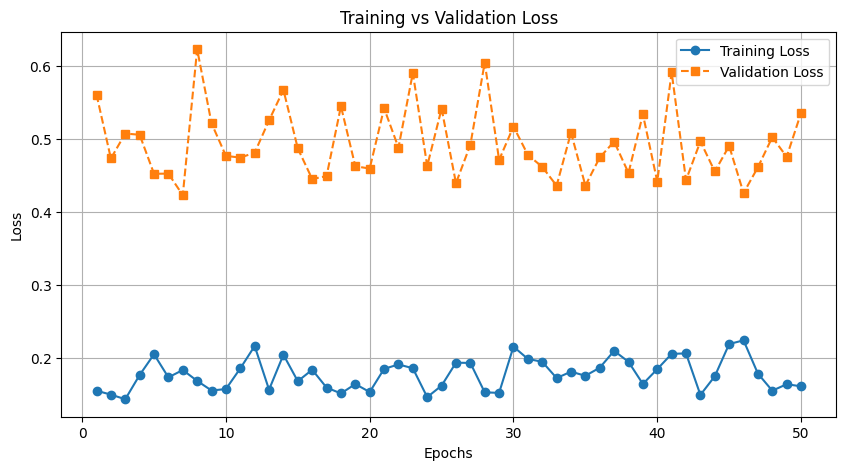

In [17]:
train_model(model, optimizer, criterion_w, train_dataloader, val_dataloader, config.num_epochs, device,config.num_classes, model_path="best_model2.pth", csv_name="training_results2.csv")

# **10 - Model Inference**

In [18]:
best_model_path = "/kaggle/working/best_model2.pth"
inference_model(model, best_model_path, test_dataloader, device, config.num_classes)

<ipython-input-14-b3e7f31363f2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]


Inference Completed in 1.15s

Macro Precision: 0.7667, Macro Recall: 0.7500, Macro F1-score: 0.7540
Class 0 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 1 - Precision: 0.6000, Recall: 0.6000, F1-score: 0.6000
Class 2 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000


<ipython-input-10-01d6a2be464f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)
